In [50]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import ast                          # importing abstract syntax tree to allow the parsing of string based lists as lists  

### **Import and Limit CSV**

In [51]:
# Filepath
csv_filepath =  "../../data/processed/cleaned_listings.csv"

# Read CSV
listings_cleaned = pd.read_csv(csv_filepath)

# Limit CSV
listings_amenities = listings_cleaned[['id', 'amenities']].copy()

# Display CSV
listings_amenities

,id,amenities
0,696407278180533419,"[""Hair dryer"", ""Central heating"", ""Paid parkin..."
1,696457318817239920,"[""Hair dryer"", ""Central heating"", ""Shampoo"", ""..."
2,696460661218975906,"[""Hair dryer"", ""Central heating"", ""Shampoo"", ""..."
3,696602542310304703,"[""Hair dryer"", ""Room-darkening shades"", ""Keypa..."
4,696638535490228478,"[""Pool table"", ""Dedicated workspace"", ""Exercis..."
...,...,...
15106,1366954101885217722,"[""Heating"", ""Shampoo"", ""Iron"", ""Body soap"", ""B..."
15107,1366970333908472070,"[""Hair dryer"", ""Room-darkening shades"", ""Eleva..."
15108,1366999672978459092,"[""Pool table"", ""Fire extinguisher"", ""Outdoor d..."
15109,1367290343089381102,"[""Keypad"", ""Heating"", ""Iron"", ""Body soap"", ""Be..."


### **Apply Abstract Syntax Tree**
Allows the stringified list in amenities to be turned into an accessible list

In [52]:
# Apply AST
listings_amenities['amenities'] = listings_amenities['amenities'].apply(ast.literal_eval)

### **Explode Dataset**

In [53]:
# Explode amenities Column
exploded_amenities = listings_amenities.explode('amenities')

# Display Exploded amenities
exploded_amenities

,id,amenities
0,696407278180533419,Hair dryer
0,696407278180533419,Central heating
0,696407278180533419,Paid parking garage on premises
0,696407278180533419,Shampoo
0,696407278180533419,Iron
...,...,...
15110,1367402901303182875,Fire pit
15110,1367402901303182875,BBQ grill
15110,1367402901303182875,Washer
15110,1367402901303182875,Pool


### **Amenity Grouping**

In [54]:
# Create Amenity Grouping Dictionary
amenity_grouping = {
    # Grouped Coffee makers
    "Coffee": "Coffee maker",
    "Coffee maker: drip coffee maker": "Coffee maker",
    "Coffee maker: Keurig coffee machine": "Coffee maker",

    # Heating / AC
    "Central heating": "Heating",
    "Central air conditioning": "Air conditioning",

    # Washers / Dryers
    "Free washer – In unit": "Washer",
    "Free dryer – In unit": "Dryer",

    # Cooking tools
    "Baking sheet": "Cooking basics",
    "Electric stove": "Stove",
    "Mini fridge": "Refrigerator",
    "Barbecue utensils": "BBQ grill",
    "Stainless steel oven": "Oven",

    # Privacy / security
    "Lock on bedroom door": "Private room lock",
    "Exterior security cameras on property": "Security camera",

    # Furniture
    "Clothing storage: closet": "Clothing storage",
    "Closet": "Clothing storage",
    "Clothing storage: closet and dresser": "Clothing storage",
    "Drying rack for clothing": "Drying rack",
    
    # Patios
    "Private patio or balcony": "Patio or balcony",
    
    # Extras
    "Exercise equipment": "Gym",
    "Shared gym in building": "Gym",
    "Private backyard – Fully fenced": "Backyard"
}

# Apply mapping to exploded_amenities - essentially renaming similar or same amenities
exploded_amenities['amenities'] = exploded_amenities['amenities'].replace(amenity_grouping)

### **Amenity Selection**

In [55]:
# List of Amenities (to KEEP)
basic_amenities = [
    "Smoke alarm", "Carbon monoxide alarm", "Hot water", "Heating", "Essentials", 
    "Bed linens", "Shampoo", "Shower gel", "Body soap", "Hangers", "Hair dryer",
    "Conditioner", "Fire extinguisher", "Cleaning products", "Private room lock"
]

convenience_amenities = [
    "Wifi", "Kitchen", "Microwave", "Refrigerator", "Freezer", "Cooking basics",
    "Stove", "Oven", "Iron", "Air conditioning", "TV", "Washer", "Dryer", "Dishwasher",
    "Coffee maker", "Hot water kettle", "Self check-in", "Elevator", "Drying rack",
    "Dedicated workspace", "Room-darkening shades", "Free parking on premises",
    "Dishes and silverware", "Dining table", "Toaster", "Extra pillows and blankets",
    "First aid kit", "Wine glasses", "Bathtub", "Outdoor furniture", 'Lockbox', 'Keypad',
    "Paid parking on premises", "Clothing storage", "Blender", "Portable fans",
    "Free street parking", 'Ethernet connection', 'Paid parking off premises',
    "Smart lock", "Rice maker", "Paid street parking off premises"
]

special_amenities = [
    "Hot tub", "Pool", "Private entrance", "BBQ grill", "Fire pit",
    "Outdoor dining area", "Patio or balcony", "Gym", "Lake access",
    "Indoor fireplace", "Sound system", "Game console", "EV charger",
    "Security camera", "Pets allowed", "Books and reading material",
    "Backyard", "City skyline view", "Board games"
]

# might remove these as they're administrative or potentially non relevant at best
other_amenities = [
    'Long term stays allowed', 'Luggage dropoff allowed', 'Laundromat nearby', 
    'Host greets you', 'Single level home', 'Cleaning available during stay'
]

# put together for all amenities to be included
complete_amenities = basic_amenities + convenience_amenities + special_amenities + other_amenities

### **Amenity Standardization**

In [56]:
# Standardized Amenities
amenities_clean = []

# Cycle and filter out the amenities on the lists above
for index, row in exploded_amenities.iterrows():
    if row['amenities'] in complete_amenities:
        amenities_clean.append(row)

# Convert amenities_cleaned back into Dataframe
amenities_cleaned = pd.DataFrame(amenities_clean)

# Drop instances of duplicates
amenities_cleaned = amenities_cleaned.drop_duplicates()

### **Amenity Binary encoding by pd.get_dummies** - Method 1 for ML 
- may be best but also may just be considered to be a lot of noise ( will require a round of feature importance to determine whether all columns are beneficial)

In [57]:
# Use pd.get_dummies to make categories ingestible for ML
amenity_dummies = pd.get_dummies(amenities_cleaned, columns=['amenities'])

# Group by id and then sum rows to limit back to 1 row per listing
listing_binary_amenities = amenity_dummies.groupby('id').sum().reset_index()

# Clean up column titles
listing_binary_amenities.columns = listing_binary_amenities.columns.str.replace(" ", "_")

listing_binary_amenities

,id,amenities_Air_conditioning,amenities_BBQ_grill,amenities_Backyard,amenities_Bathtub,amenities_Bed_linens,amenities_Blender,amenities_Board_games,amenities_Body_soap,amenities_Books_and_reading_material,...,amenities_Single_level_home,amenities_Smart_lock,amenities_Smoke_alarm,amenities_Sound_system,amenities_Stove,amenities_TV,amenities_Toaster,amenities_Washer,amenities_Wifi,amenities_Wine_glasses
0,26654,1,0,0,1,1,1,0,0,1,...,1,0,1,0,1,0,1,1,1,1
1,40701,1,0,0,1,1,1,0,1,1,...,0,0,1,0,1,0,1,1,1,1
2,44452,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,1,0
3,45399,1,0,0,1,1,0,0,0,0,...,1,0,1,0,1,0,1,1,1,0
4,45893,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15097,1366954101885217722,1,1,1,1,1,0,0,1,0,...,0,1,1,0,1,1,1,1,1,0
15098,1366970333908472070,1,1,0,1,1,1,1,0,0,...,0,0,1,0,1,1,1,1,1,1
15099,1366999672978459092,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
15100,1367290343089381102,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### **Amenity Categorization**

In [58]:
# Function to define amenity by predefined lists
def categorize_amenity(amenity):
    if amenity in basic_amenities:
        return 'basic'
    elif amenity in convenience_amenities:
        return 'convenience'
    elif amenity in special_amenities:
        return 'special'
    elif amenity in other_amenities :
        return 'other'

# Apply function to amenities and save to new column
amenities_cleaned['amenity_classification'] = amenities_cleaned['amenities'].apply(categorize_amenity)

### **Amenity Category counts by listing_id**  - Method 2 for ML
- Categorized by a system of 4 categories myself with common sense which might be considered inaccurate.

In [59]:
# Count Categories
amenities_counts = amenities_cleaned.groupby(['id', 'amenity_classification']).size().unstack(fill_value=0).reset_index()

# Rename Columns
amenities_counts = amenities_counts.rename(columns={
    'basic': 'basic_amenities_count',
    'convenience': 'convenience_amenities_count',
    'special': 'special_amenities_count',
    'other': 'other_amenities_count'
})

# Total Amenity count
amenities_counts['total_amenities_count'] = amenities_counts['basic_amenities_count'] + amenities_counts['convenience_amenities_count'] + amenities_counts['special_amenities_count'] + amenities_counts['other_amenities_count']

amenities_counts

amenity_classification,id,basic_amenities_count,convenience_amenities_count,other_amenities_count,special_amenities_count,total_amenities_count
0,26654,12,31,3,6,52
1,40701,9,32,2,4,47
2,44452,8,17,1,0,26
3,45399,10,20,3,2,35
4,45893,7,17,0,0,24
...,...,...,...,...,...,...
15097,1366954101885217722,12,28,2,8,50
15098,1366970333908472070,12,31,2,5,50
15099,1366999672978459092,3,7,0,4,14
15100,1367290343089381102,5,11,1,2,19


### **EDA**

### Top 20 most Common Amenities

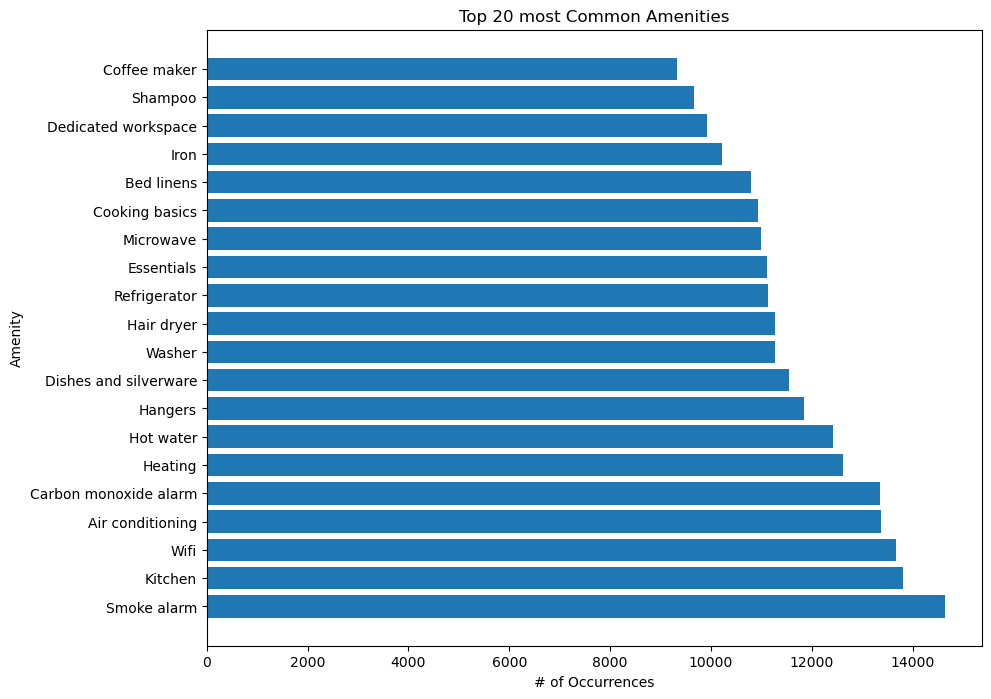

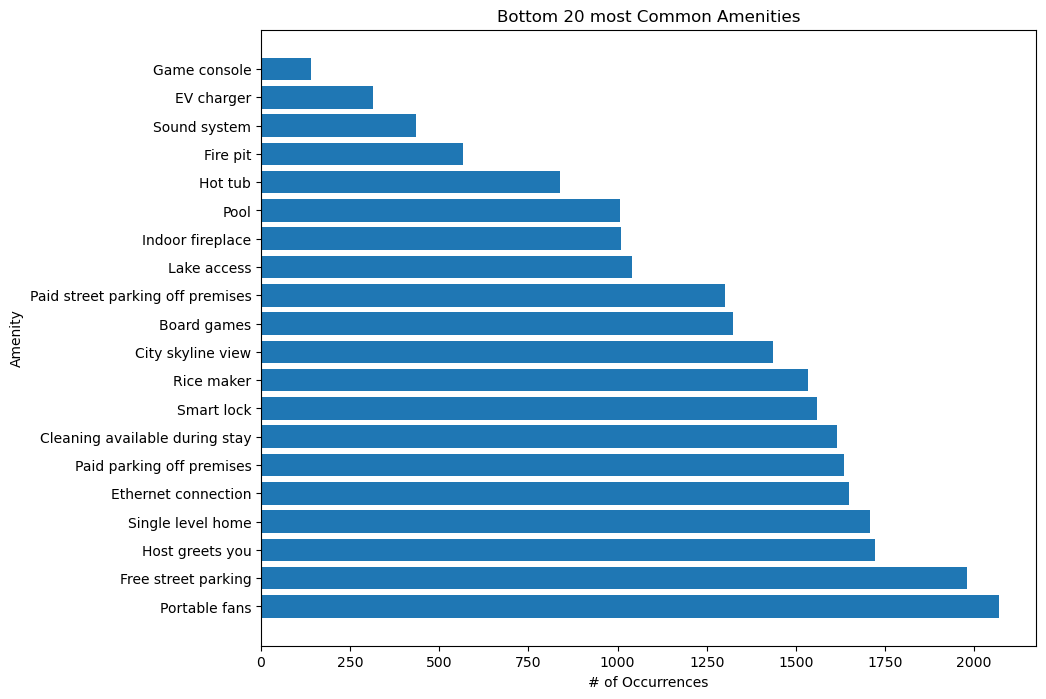

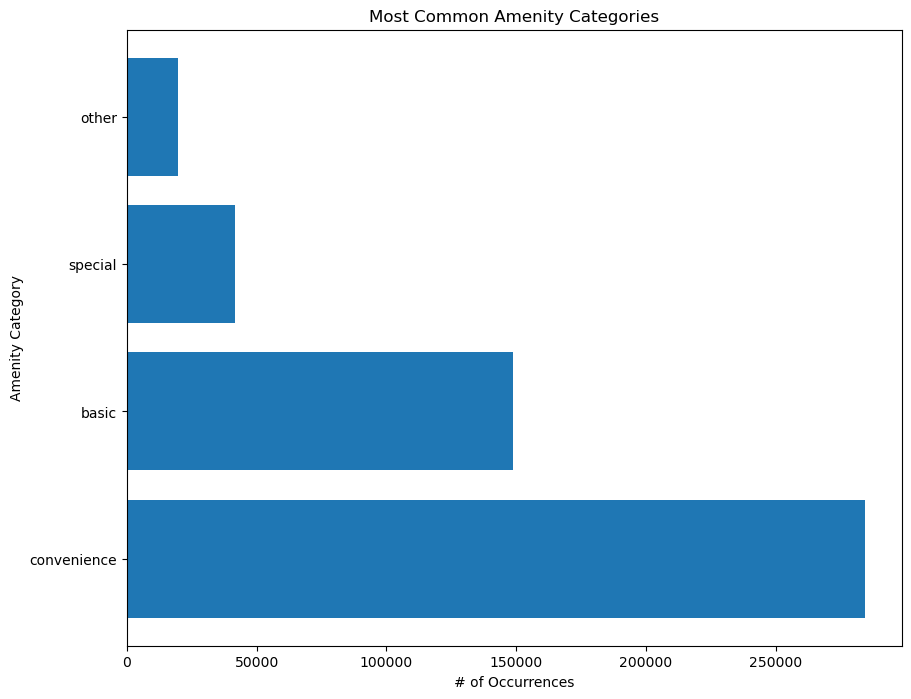

amenities
Smoke alarm              14638
Kitchen                  13805
Wifi                     13671
Air conditioning         13375
Carbon monoxide alarm    13353
Heating                  12620
Hot water                12414
Hangers                  11838
Dishes and silverware    11548
Washer                   11271
Hair dryer               11266
Refrigerator             11127
Essentials               11110
Microwave                10982
Cooking basics           10936
Bed linens               10789
Iron                     10226
Dedicated workspace       9930
Shampoo                   9659
Coffee maker              9335
Name: count, dtype: int64

In [60]:
# Aggregate amenity rankings

top_amenities = amenities_cleaned['amenities'].value_counts().head(20)
bottom_amenities = amenities_cleaned['amenities'].value_counts().tail(20)
top_classifications = amenities_cleaned['amenity_classification'].value_counts().head(4)

# Plot top amenities
plt.figure(figsize=(10,8))
plt.barh(top_amenities.index, top_amenities.values)
plt.title('Top 20 most Common Amenities')
plt.xlabel('# of Occurrences')
plt.ylabel('Amenity')

plt.show()

# Plot bottom amenities
plt.figure(figsize=(10,8))
plt.barh(bottom_amenities.index, bottom_amenities.values)
plt.title('Bottom 20 most Common Amenities')
plt.xlabel('# of Occurrences')
plt.ylabel('Amenity')

plt.show()

# Rank amenities categories
plt.figure(figsize=(10,8))
plt.barh(top_classifications.index, top_classifications.values)
plt.title('Most Common Amenity Categories')
plt.xlabel('# of Occurrences')
plt.ylabel('Amenity Category')

plt.show()

top_amenities

### Evaluation
Given that this data is drawn from listings in the Greater Toronto Area, the distribution of amenities aligns well with expectations for an urban, city-based environment. The top amenities—such as smoke alarms, kitchens, WiFi, heating, and refrigerators—highlight a strong presence of basic modern living necessities. Interestingly though, the "convenience" category dominates in total count, this is likely due to the broader range of amenities classified under it, rather than any specific amenity being especially common. In fact, the top 20 individual amenities appear to lean more toward basic necessities rather than truly convenience-oriented features, which reveals a bit of imbalance in the category groupings, so Ill have to fix that.

In [61]:
listing_binary_amenities

,id,amenities_Air_conditioning,amenities_BBQ_grill,amenities_Backyard,amenities_Bathtub,amenities_Bed_linens,amenities_Blender,amenities_Board_games,amenities_Body_soap,amenities_Books_and_reading_material,...,amenities_Single_level_home,amenities_Smart_lock,amenities_Smoke_alarm,amenities_Sound_system,amenities_Stove,amenities_TV,amenities_Toaster,amenities_Washer,amenities_Wifi,amenities_Wine_glasses
0,26654,1,0,0,1,1,1,0,0,1,...,1,0,1,0,1,0,1,1,1,1
1,40701,1,0,0,1,1,1,0,1,1,...,0,0,1,0,1,0,1,1,1,1
2,44452,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,1,0
3,45399,1,0,0,1,1,0,0,0,0,...,1,0,1,0,1,0,1,1,1,0
4,45893,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15097,1366954101885217722,1,1,1,1,1,0,0,1,0,...,0,1,1,0,1,1,1,1,1,0
15098,1366970333908472070,1,1,0,1,1,1,1,0,0,...,0,0,1,0,1,1,1,1,1,1
15099,1366999672978459092,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
15100,1367290343089381102,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


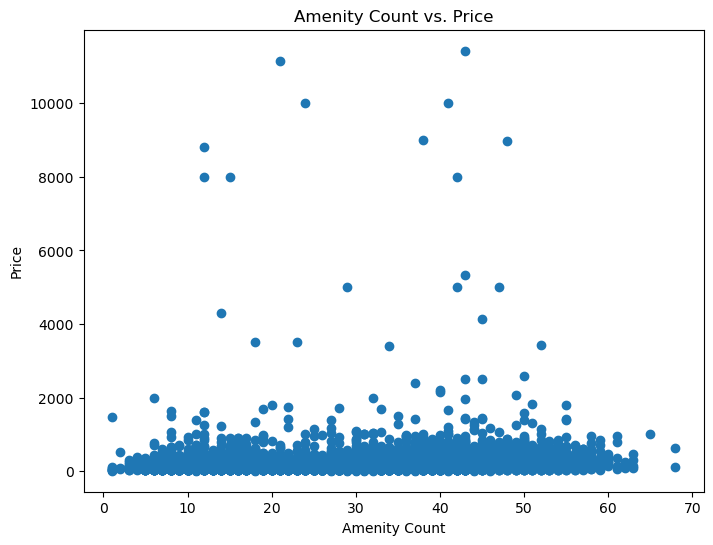

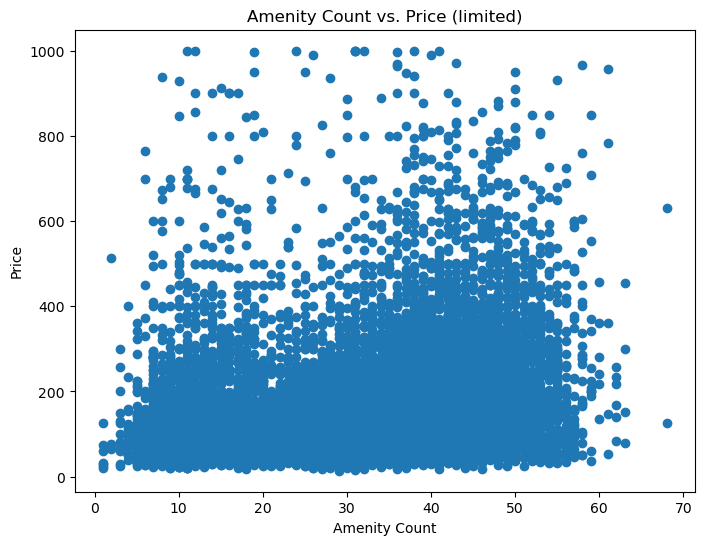

In [64]:
# Total amenity count
amenity_count = amenities_cleaned.groupby('id')['amenities'].count()

# Merge Amenity Count
merged_df = pd.merge(amenities_counts[['id', 'total_amenities_count']],
                    listings_cleaned[['id', 'price']],
                    on='id')

# Plot Amenity Count by Price
plt.figure(figsize=(8,6))
plt.scatter(merged_df['total_amenities_count'], merged_df['price'])
plt.xlabel('Amenity Count')
plt.ylabel('Price')
plt.title('Amenity Count vs. Price')
plt.show()

# Apply Price limit of 1000
merged_df = merged_df[merged_df['price']<=1000]

# Plot Amenity Count by Price
plt.figure(figsize=(8,6))
plt.scatter(merged_df['total_amenities_count'], merged_df['price'])
plt.xlabel('Amenity Count')
plt.ylabel('Price')
plt.title('Amenity Count vs. Price (limited)')
plt.show()

### Evaluation
Looking at the data straight after merging the amenity counts with listing prices, the scatter plot shows no strong linear correlation. With prices reaching well above $10,000, it's clear that the dataset contains several outliers that need to be filtered out.

Upon limiting the data to listings priced at $1,000 or less, the visualization becomes much more interpretable. Outliers above this threshold clearly skewed the plot, as a soft upward trend begins to emerge in the filtered data. This proves that while amenity count alone doesn’t or cannot dictate price, larger numbers of amenities around 35-55 does appear to loosely align with the higher-value or just large range of price of listings, reinforcing its potential role as a contributing factor in future pricing models.